In [1]:
%pip install scipy==1.12
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 54.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 17.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Version simple présenté sur le site de Kaggle (vecteurs à 2 dimensions)

MMD result of X and Y is 0.392077773809433


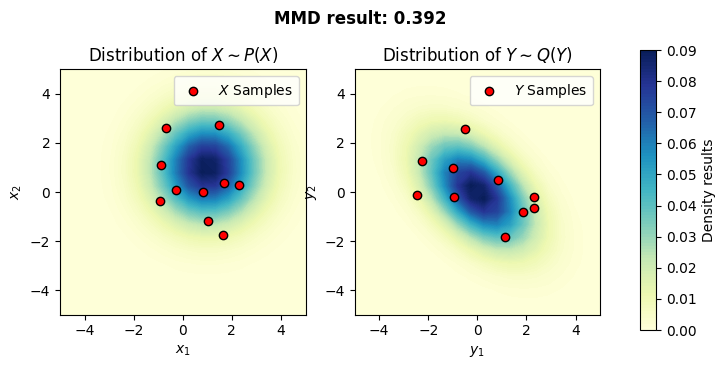

In [21]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)
    

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)

qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
#print(x)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)
x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title(r"Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title(r"Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)


cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()



## We want to we want to check if the distance is indeed 0 for 2 same distributions


MMD result of X and Y is 0.007288265973329544


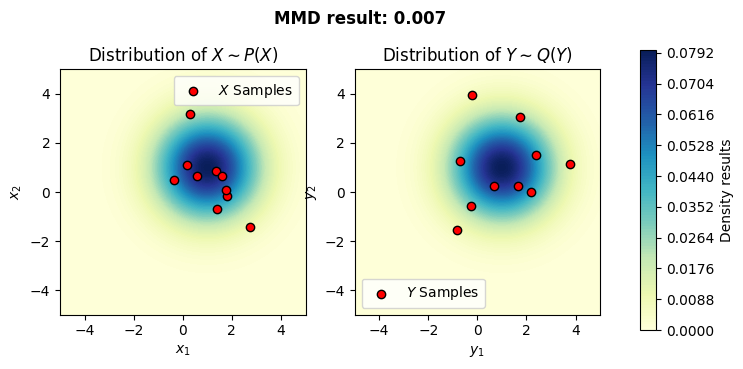

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)
    

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 1000 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(x_mean, x_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)
x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)



# Faute de place, on affiche uniquement les 10 premiers points sur les graphes 


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title(r"Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title(r"Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)


cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()



## Indeed, when the sample tend to infinite, (for instance with 100 or 1000), the value of the distance is tending to 0. For sample higher then 100, dont try to show the graphic because it will freeze

# New Test but with larger vector (10 dimensions) 

In [2]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result,
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

# Sample size
m = 20

# Generate data
x_mean = torch.zeros(10) + 1
y_mean = torch.zeros(10)

# Properly defined positive definite covariance matrices
x_cov = 2 * torch.eye(10)  # Covariance matrix for X
y_cov = 2 * torch.eye(10)  # Different positive definite covariance matrix for Y

# Distributions
px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)


# Generate samples
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

print(x)

# Calculate MMD
result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")


tensor([[ 0.5176, -0.1526,  1.1153, -2.7603, -0.5345,  2.6981,  1.7114,  1.1825,
          2.2716, -0.2942],
        [-0.5025,  1.2349,  0.4010,  1.8917,  1.6833,  0.9195, -1.1569,  1.8929,
         -0.0920,  1.2872],
        [ 2.5609, -0.2747, -0.3781,  0.5319,  1.3726,  3.6672,  0.1640, -0.3106,
          0.5943, -0.3649],
        [ 1.6276,  0.0484, -0.2525,  2.1168,  1.8645, -0.0902,  3.5242,  1.7597,
         -0.8805,  0.3373],
        [-2.1559,  2.4383,  4.0257, -0.6944,  2.5918,  0.3273,  0.3592, -1.0301,
          1.7640,  0.9948],
        [ 2.1820,  2.3623,  1.8601,  2.2395,  0.5269,  0.6429,  0.5945,  2.0914,
          1.2946,  0.5438],
        [ 2.1463,  3.0045,  2.2591,  1.3239, -1.0786, -0.0735, -0.4214, -0.1763,
          1.7869, -0.6432],
        [ 2.0262,  0.7540, -1.6046,  1.4684,  1.8514,  0.5535,  1.7098,  0.8409,
          1.2579,  2.1579],
        [ 0.9122,  2.6025,  1.0243,  0.6082,  1.0504,  0.1002, -1.0647,  1.4930,
          1.1327, -0.6540],
        [ 1.5915,  

## Same for identical vectors 

In [18]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result,
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

# Sample size
m = 10000

# Generate data
x_mean = torch.zeros(10) + 1
y_mean = torch.zeros(10)

# Properly defined positive definite covariance matrices
x_cov = 2 * torch.eye(10)  # Covariance matrix for X
y_cov = 2 * torch.eye(10)  # Different positive definite covariance matrix for Y

# Distributions
px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(x_mean, x_cov)

# Generate samples
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

# Calculate MMD
result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")


MMD result of X and Y is 0.0007990764570422471


# Offline Clustering Algorithm with MMD Distance

In [11]:
import numpy as np
import torch

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    device = x.device  # Assure que le device est bien utilisé dans la fonction
    
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
    
    return torch.mean(XX + YY - 2. * XY)

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)

    # Convert data to tensor for MMD function
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1], torch.tensor([center], dtype=torch.float32).to(device), kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters

# Test the algorithm
def test_offline_clustering():
    # np.random.seed(0)
    # data = np.random.rand(10, 2)
    # 3 vecteurs générés par une loi gaussienne avec moyenne 2 et ecart type 1 
    gaussian_data3 = np.random.normal(loc=2, scale=1, size=(10, 10))
    #print(gaussian_data3)
    

    # 3 vecteurs générés par une loi gaussienne avec moyenne 0 et écart type 1
    gaussian_data1 = np.random.normal(loc=0, scale=1, size=(10, 10))

    # 4 vecteurs générés par une autre loi gaussienne avec moyenne 5 et écart type 2
    gaussian_data2 = np.random.normal(loc=5, scale=5, size=(10, 10))

    # Concaténer tous les vecteurs pour former le jeu de données complet
    data = np.concatenate((gaussian_data3, gaussian_data1, gaussian_data2), axis=0)

    #print("data :" , data)
    print("len(data) :" , len(data))

    
    #print(data)
    k = 3

    clusters = offline_clustering(data, k, kernel="rbf", device='cpu')

    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")

test_offline_clustering()


len(data) : 30


/tmp/ipykernel_112/2635408367.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])


Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 26, 27, 28, 29]
Cluster 1: [25]
Cluster 2: [19, 10, 11, 12, 13, 14, 15, 16, 17, 18]


## The results are not those that we are waiting for so we try New tests with just 2 bernoulli  

In [6]:
import numpy as np
import torch

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    device = x.device  # Assure que le device est bien utilisé dans la fonction
    
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
    
    return torch.mean(XX + YY - 2. * XY)

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)

    # Convert data to tensor for MMD function
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1], torch.tensor([center], dtype=torch.float32).to(device), kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel, device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters

# Test the algorithm
def test_offline_clustering():
    sample = 10#(nombre d'échantillon par lois)
    d = 100 #dimension des vecteurs
    # 2 vecteurs aléatoires de bernoulli 
    bernoulli_data1 = np.random.binomial(n=1, p=0.3, size=(sample, d))
    #print(bernoulli_data1[:2])
    # Générer un vecteur de Bernoulli avec paramètre 0.9
    bernoulli_data2 = np.random.binomial(n=1, p=0.6, size=(sample, d))
    print(bernoulli_data2[:2])
    print(len(bernoulli_data1))
    # Concaténer les deux vecteurs pour former le jeu de données complet
    data = np.concatenate((bernoulli_data1, bernoulli_data2), axis=0)
    k = 2
    clusters = offline_clustering(data, k, kernel="multiscale", device='cpu')
    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")

test_offline_clustering()


[[1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1
  0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0
  1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0]
 [0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
  0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0
  0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0]]
Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13]
Cluster 1: [18, 10, 12, 14, 15, 16, 17, 19]


In [51]:
import numpy as np
import torch

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    device = x.device  # Assure que le device est bien utilisé dans la fonction
    
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
    
    return torch.mean(XX + YY - 2. * XY)

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)

    # Convert data to tensor for MMD function
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1], torch.tensor([center], dtype=torch.float32).to(device), kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel, device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters

# Test the algorithm
def test_offline_clustering():

    sample = 10#(nombre d'échantillon par lois)
    d = 300 #dimension des vecteurs
    # 3 vecteurs générés par une loi gaussienne avec moyenne 2 et ecart type 1 
    gaussian_data3 = np.random.normal(loc=2, scale=1, size=(sample, d))
    #print(gaussian_data3[:5])
    

    # 3 vecteurs générés par une loi gaussienne avec moyenne 0 et écart type 1
    gaussian_data1 = np.random.normal(loc=0, scale=1, size=(sample, d))

    # 4 vecteurs générés par une autre loi gaussienne avec moyenne 5 et écart type 2
    gaussian_data2 = np.random.normal(loc=1, scale=1, size=(sample, d))

    # Concaténer tous les vecteurs pour former le jeu de données complet
    data = np.concatenate(( gaussian_data2,gaussian_data1,gaussian_data3), axis=0)

    #print("data :" , data)
    #print("len(data) :" , len(data))
    #print("caca")
    
    #print(data)
    k = 3
    clusters = offline_clustering(data, k, kernel="rbf", device='cpu')

    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")

test_offline_clustering()


Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Cluster 1: [23, 20, 21, 22, 24, 25, 26, 27, 28, 29]
Cluster 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


# Je m'étais rendu compte qu'il y avait un probleme dans tout ce que l'on testait : on l'appliquait à des éléments de dimension trop faible, ainsi, j"ai retravaillé le code de l'algorithme pour corriger tout ces problèmes et voici ce que l'on obtient désormais, dans le cas ou l'on a 10 séquences, 5 suivant une meme loi, 5 une autre, et chaques séquences contient n = 10 vecteurs, de dimensions d   

In [3]:
import numpy as np
import torch

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    device = x.device  # Assure que le device est bien utilisé dans la fonction
    
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
    
    return torch.mean(XX + YY - 2. * XY)

In [39]:
import numpy as np
import torch

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)
    data_tensor= data
    #data_tensor = torch.stack(data).to(device)
    #print("data_tensor : ",data_tensor)
    print( "len(data_tensor) :" , len(data_tensor))
    # Convert data to tensor for MMD function
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            # print( "data_tensor[i:i+1] : ", data_tensor[i:i+1])
            # print( "data_tensor[i:i+1][0] : ", data_tensor[i:i+1][0])
            # print( "centers[0] : ", centers[0])
            # #print("Shape of data_tensor[i:i+1]: ", data_tensor[i:i+1].shape)
            # print("Shape of data_tensor[i:i+1][0]: ", data_tensor[i:i+1][0].shape)
            # print("Shape of centers[0]: ", centers[0].shape)
            # print("centers[0]: ", centers[0])

            
            #print(MMD(data_tensor[i:i+1][0],centers[0],"rbf").item())
            #mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            mmd_dist = max([MMD(data_tensor[i:i+1][0], centers[j], kernel).item() for j in range(len(centers))])
            #print("ok")
            
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    data_tensor = data

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        #print(centers)
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1][0], center, kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters

# Test the algorithm
def test_offline_clustering():
    n = 1000 # sample size, taille de l'échantillon
    m = 5  # number of similar samples for x and y
    d = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_mean = torch.zeros(d) + 0.1
    y_mean = torch.zeros(d)
    # x_cov = 2 * torch.eye(d)  # Covariance matrix for X
    # y_cov = 4 * torch.eye(d)  # Covariance matrix for Y
    x_cov = torch.eye(d)  # Covariance matrix for X
    y_cov = torch.eye(d)  # Covariance matrix for Y
    # Distributions
    px = torch.distributions.MultivariateNormal(x_mean, x_cov)
    qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
    # Generate n samples for each distribution
    x_samples = [px.sample([n]).to(device) for _ in range(m)]
    y_samples = [qy.sample([n]).to(device) for _ in range(m)]
    # Combine them into a single list
    xy_list = x_samples + y_samples
    print("len(xy_list) : " , len(xy_list))
    k = 2
    print( "n : ", n )
    clusters = offline_clustering(xy_list, k, kernel="rbf", device='cpu')
    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")
test_offline_clustering()


len(xy_list) :  10
n :  1000
len(data_tensor) : 10
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [5, 6, 7, 8, 9]


### Pour un petit test, retournons vers le cas de Bernoulli. On fixe la dimension à 1 au lieu de 300. On génère 10 séquences de longueur n=100, les premier 3 séquences sont iid Bern(p=0.3) et le reste sont iid Bern(p=0.6) et on calcul l’erreur de classification. On répète la même chose pour n=500,1000,1500,2000,2500,3000 et génère un graphe des erreurs,

## Taux d'erreur dans le cas ou k = 2 (2 clusters)

n :  5
Cluster 0: [0, 1, 2, 3, 4, 5, 8, 9]
Cluster 1: [6, 7]
n :  20
Cluster 0: [0, 2, 7]
Cluster 1: [9, 1, 3, 4, 5, 6, 8]
n :  35
Cluster 0: [0, 1, 2]
Cluster 1: [5, 3, 4, 6, 7, 8, 9]
n :  50
Cluster 0: [0, 1, 2, 3]
Cluster 1: [5, 4, 6, 7, 8, 9]
n :  65
Cluster 0: [0, 1, 2, 5]
Cluster 1: [3, 4, 6, 7, 8, 9]
n :  80
Cluster 0: [0, 1, 2]
Cluster 1: [5, 3, 4, 6, 7, 8, 9]
n :  95
Cluster 0: [0, 1, 2, 6]
Cluster 1: [9, 3, 4, 5, 7, 8]
n :  110
Cluster 0: [0, 1, 2]
Cluster 1: [9, 3, 4, 5, 6, 7, 8]
n :  125
Cluster 0: [0, 1, 2]
Cluster 1: [5, 3, 4, 6, 7, 8, 9]
n :  140
Cluster 0: [0, 1, 2]
Cluster 1: [9, 3, 4, 5, 6, 7, 8]


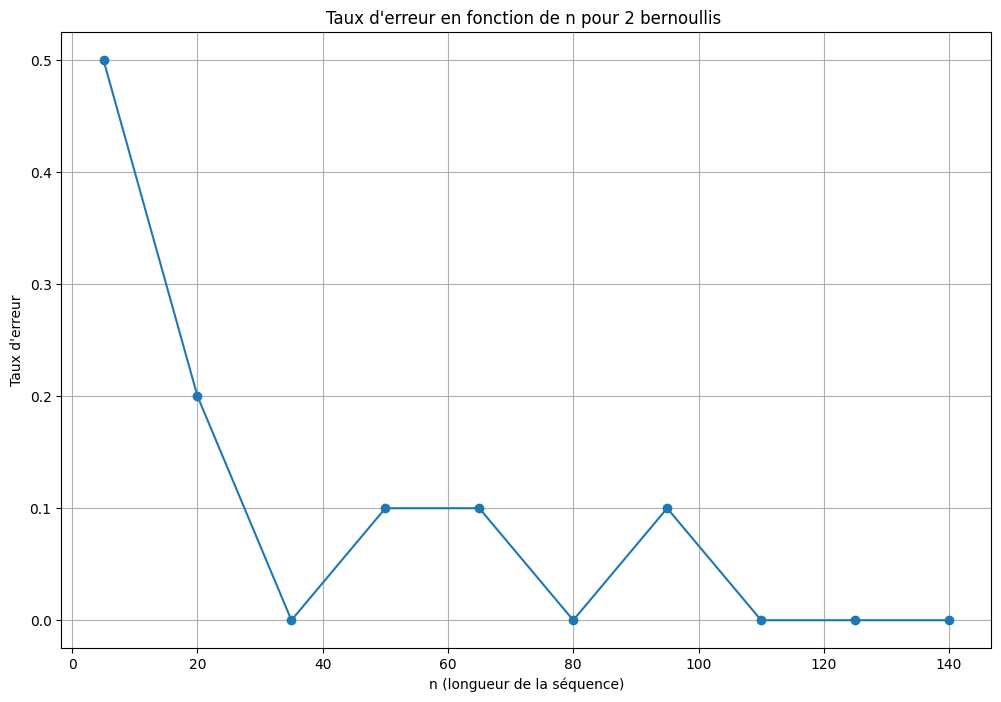

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)
    data_tensor= data
    #data_tensor = torch.stack(data).to(device)
    #print("data_tensor : ",data_tensor)
    #print( "len(data_tensor) :" , len(data_tensor))
    # Convert data to tensor for MMD function
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            # print( "data_tensor[i:i+1] : ", data_tensor[i:i+1])
            # print( "data_tensor[i:i+1][0] : ", data_tensor[i:i+1][0])
            # print( "centers[0] : ", centers[0])
            # #print("Shape of data_tensor[i:i+1]: ", data_tensor[i:i+1].shape)
            # print("Shape of data_tensor[i:i+1][0]: ", data_tensor[i:i+1][0].shape)
            # print("Shape of centers[0]: ", centers[0].shape)
            # print("centers[0]: ", centers[0])

            
            #print(MMD(data_tensor[i:i+1][0],centers[0],"rbf").item())
            #mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            mmd_dist = max([MMD(data_tensor[i:i+1][0], centers[j], kernel).item() for j in range(len(centers))])
            #print("ok")
            
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    data_tensor = data

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        #print(centers)
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1][0], center, kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters


def test_offline_clustering(n):
    # n = 10  # longueur de chaque séquence
    num_sequences = 10  # nombre total de séquences
    split_index = 3  # index de séparation entre les deux groupes
    p_low = 0.3  # probabilité pour les premières séquences
    p_high = 0.6  # probabilité pour les dernières séquences
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Paramètre des distributions de Bernoulli
    p = torch.tensor([p_low], device=device)  # Paramètre pour les premières séquences
    q = torch.tensor([p_high], device=device)  # Paramètre pour les dernières séquences
    
    # Création des distributions de Bernoulli
    bernoulli_low = torch.distributions.Bernoulli(p)
    bernoulli_high = torch.distributions.Bernoulli(q)
    
    # Génération des séquences
    sequences_low = [bernoulli_low.sample((n,)).to(device) for _ in range(split_index)]
    sequences_high = [bernoulli_high.sample((n,)).to(device) for _ in range(num_sequences - split_index)]
    
    # Combinaison des séquences
    all_sequences = sequences_low + sequences_high

    good_cluster = [[ i for i in range(len(sequences_low))],[j for j in range(len(sequences_low), len(sequences_low) + len(sequences_high))]]

    error_rate = 0 
    mis_classify = 0 


    #print(good_cluster)
    # print("len(all_sequences) :", len(all_sequences))
    
    # # Optionnel: Afficher quelques séquences pour vérifier
    # print("sequences_low[0]:", sequences_low[0])
    # print("sequences_high[0]:", sequences_high[0])
    k = 2
    print( "n : ", n )
    clusters = offline_clustering(all_sequences, k, kernel="rbf", device='cpu')

    
    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")
        for i in points : 
            if i not in good_cluster[cluster_idx]:
                mis_classify +=1
    error_rate = mis_classify / num_sequences
    #print("error_rate : ", error_rate)
    return(error_rate)
                


# Boucle pour exécuter test_offline_clustering pour différentes valeurs de n
n_values = range(5, 150, 15)
error_rates = []

for n in n_values:
    error_rate = test_offline_clustering(n)
    error_rates.append(error_rate)

plt.figure(figsize=(12, 8))
# Tracer le taux d'erreur en fonction de n
plt.plot(n_values, error_rates, marker='o')
plt.xlabel('n (longueur de la séquence)')
plt.ylabel('Taux d\'erreur')
plt.title('Taux d\'erreur en fonction de n pour 2 bernoullis ')
plt.grid(True)
plt.show()

# Exécutez la fonction
# test_offline_clustering(10)





## Taux d'erreur dans le cas ou k = 3 (3 clusters)

ok
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 2, 4, 6, 7, 9, 11]
Cluster 1: [10, 5, 8, 12, 13, 14]
Cluster 2: [1, 3]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 4, 5, 7, 8, 9]
Cluster 1: [13, 6, 10, 11, 12, 14]
Cluster 2: [2, 3]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 4, 7, 8, 9]
Cluster 1: [13, 5, 6, 10, 11, 12, 14]
Cluster 2: [2, 3]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 7, 8, 9]
Cluster 1: [13, 5, 6, 10, 11, 12, 14]
Cluster 2: [3, 1, 2, 4]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4, 6, 7]
Cluster 1: [11]
Cluster 2: [10, 5, 8, 9, 12, 13, 14]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 2, 3, 5, 6, 7, 9]
Cluster 1: [10, 8, 11, 12, 13, 14]
Cluster 2: [4, 1]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 4, 5, 7]
Cluster 1: [13, 6, 8, 9, 10, 11, 12, 14]
Cluster 2: [2, 3]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 2, 3, 4, 5, 6, 7, 9]
Cluster 1: [10, 8, 11, 12, 13, 14]
Cluster 2: [1]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 5, 7, 8, 9]
Cluster 1: [10, 6, 11, 12, 13, 14]
Cluster 2: [4]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 2, 3, 4, 5, 6, 8, 

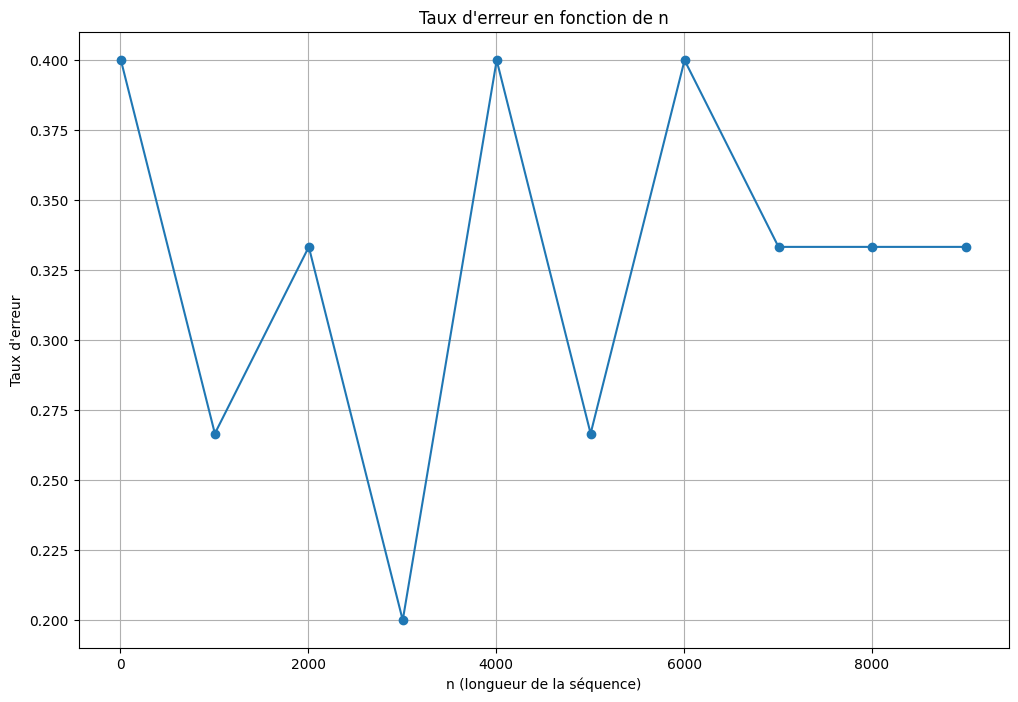

In [7]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)
    data_tensor= data
    #data_tensor = torch.stack(data).to(device)
    #print("data_tensor : ",data_tensor)
    #print( "len(data_tensor) :" , len(data_tensor))
    # Convert data to tensor for MMD function
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            # print( "data_tensor[i:i+1] : ", data_tensor[i:i+1])
            # print( "data_tensor[i:i+1][0] : ", data_tensor[i:i+1][0])
            # print( "centers[0] : ", centers[0])
            # #print("Shape of data_tensor[i:i+1]: ", data_tensor[i:i+1].shape)
            # print("Shape of data_tensor[i:i+1][0]: ", data_tensor[i:i+1][0].shape)
            # print("Shape of centers[0]: ", centers[0].shape)
            # print("centers[0]: ", centers[0])

            
            #print(MMD(data_tensor[i:i+1][0],centers[0],"rbf").item())
            #mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            mmd_dist = max([MMD(data_tensor[i:i+1][0], centers[j], kernel).item() for j in range(len(centers))])
            #print("ok")
            
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    data_tensor = data

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        #print(centers)
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1][0], center, kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters


def test_offline_clustering(n):
    num_sequences = 15  # nombre total de séquences
    split_indices = [5, 10]  # indices de séparation entre les trois groupes
    p_low = 0.3 # probabilité pour les premières séquences
    p_medium = 0.6  # probabilité pour les séquences intermédiaires
    p_high = 0.9  # probabilité pour les dernières séquences
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Paramètres des distributions de Bernoulli
    p1 = torch.tensor([p_low], device=device)  # Paramètre pour les premières séquences
    p2 = torch.tensor([p_medium], device=device)  # Paramètre pour les séquences intermédiaires
    p3 = torch.tensor([p_high], device=device)  # Paramètre pour les dernières séquences
    
    # Création des distributions de Bernoulli
    bernoulli_low = torch.distributions.Bernoulli(p1)
    bernoulli_medium = torch.distributions.Bernoulli(p2)
    bernoulli_high = torch.distributions.Bernoulli(p3)
    
    # Génération des séquences
    sequences_low = [bernoulli_low.sample((n,)).to(device) for _ in range(split_indices[0])]
    sequences_medium = [bernoulli_medium.sample((n,)).to(device) for _ in range(split_indices[1] - split_indices[0])]
    sequences_high = [bernoulli_high.sample((n,)).to(device) for _ in range(num_sequences - split_indices[1])]
    
    # Combinaison des séquences
    all_sequences = sequences_low + sequences_medium + sequences_high

    # Définition des clusters corrects
    good_cluster = [
        [i for i in range(len(sequences_low))],
        [j for j in range(len(sequences_low), len(sequences_low) + len(sequences_medium))],
        [k for k in range(len(sequences_low) + len(sequences_medium), len(all_sequences))]
    ]
    
    permutations_list = list(itertools.permutations(good_cluster))

    mis_classify = [0 for i in range(6)]
    print(mis_classify)
    

    k = 3  # nombre de clusters
    clusters = offline_clustering(all_sequences, k, kernel="rbf", device='cpu')

    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")
        for j in range(len(permutations_list)):
            for i in points:
                if i not in permutations_list[j][cluster_idx]:
                    mis_classify[j] += 1
    
    error_rate = min(mis_classify) / num_sequences
    return error_rate
                



# n=1000
print("ok")
# test_offline_clustering(n)

# Boucle pour exécuter test_offline_clustering pour différentes valeurs de n
n_values = range(5, 10000, 1000)
error_rates = []

for n in n_values:
    error_rate = test_offline_clustering(n)
    error_rates.append(error_rate)

plt.figure(figsize=(12, 8))
# Tracer le taux d'erreur en fonction de n
plt.plot(n_values, error_rates, marker='o')
plt.xlabel('n (longueur de la séquence)')
plt.ylabel('Taux d\'erreur')
plt.title('Taux d\'erreur en fonction de n')
plt.grid(True)
plt.show()







## test similaire avec des lois gaussiennes premier cas : k=2 

Cluster 0: [0, 2, 6, 7, 8]
Cluster 1: [9, 1, 3, 4, 5]
Cluster 0: [0, 4, 5, 6, 7, 8, 9]
Cluster 1: [3, 1, 2]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [8, 5, 6, 7, 9]
Cluster 0: [0, 1, 2, 3, 4, 5]
Cluster 1: [6, 7, 8, 9]
Cluster 0: [0, 1, 2, 3, 4, 6, 9]
Cluster 1: [8, 5, 7]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [7, 5, 6, 8, 9]
Cluster 0: [0, 1, 2, 3]
Cluster 1: [7, 4, 5, 6, 8, 9]
Cluster 0: [0, 1, 2, 3, 4, 5]
Cluster 1: [7, 6, 8, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [8, 5, 6, 7, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [7, 5, 6, 8, 9]
Cluster 0: [0, 1, 2, 3, 4, 5]
Cluster 1: [7, 6, 8, 9]
Cluster 0: [0, 1, 2, 3, 4, 8]
Cluster 1: [6, 5, 7, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [8, 5, 6, 7, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [5, 6, 7, 8, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [7, 5, 6, 8, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [9, 5, 6, 7, 8]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [6, 5, 7, 8, 9]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [8, 5, 6, 7, 9]
Cluster 0: [0, 1, 2, 3, 4, 9

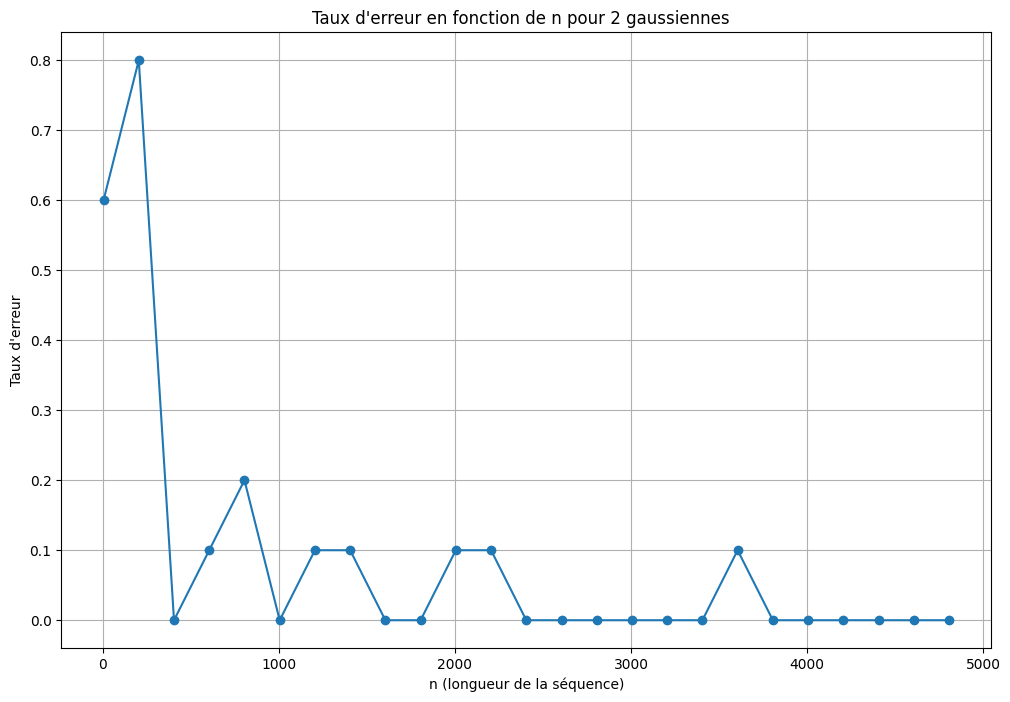

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)
    data_tensor= data
    #data_tensor = torch.stack(data).to(device)
    #print("data_tensor : ",data_tensor)
    #print( "len(data_tensor) :" , len(data_tensor))
    # Convert data to tensor for MMD function
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            # print( "data_tensor[i:i+1] : ", data_tensor[i:i+1])
            # print( "data_tensor[i:i+1][0] : ", data_tensor[i:i+1][0])
            # print( "centers[0] : ", centers[0])
            # #print("Shape of data_tensor[i:i+1]: ", data_tensor[i:i+1].shape)
            # print("Shape of data_tensor[i:i+1][0]: ", data_tensor[i:i+1][0].shape)
            # print("Shape of centers[0]: ", centers[0].shape)
            # print("centers[0]: ", centers[0])

            
            #print(MMD(data_tensor[i:i+1][0],centers[0],"rbf").item())
            #mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            mmd_dist = max([MMD(data_tensor[i:i+1][0], centers[j], kernel).item() for j in range(len(centers))])
            #print("ok")
            
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    data_tensor = data

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        #print(centers)
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1][0], center, kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters


def test_offline_clustering(n):
    
    m = 5  # number of similar samples for x and y
    d = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_mean = torch.zeros(d) + 0.1
    y_mean = torch.zeros(d)
    # x_cov = 2 * torch.eye(d)  # Covariance matrix for X
    # y_cov = 4 * torch.eye(d)  # Covariance matrix for Y
    x_cov = torch.eye(d)  # Covariance matrix for X
    y_cov = torch.eye(d)  # Covariance matrix for Y
    # Distributions
    px = torch.distributions.MultivariateNormal(x_mean, x_cov)
    qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
    # Generate n samples for each distribution
    x_samples = [px.sample([n]).to(device) for _ in range(m)]
    y_samples = [qy.sample([n]).to(device) for _ in range(m)]
    # Combine them into a single list
    all_sequences = x_samples + y_samples
    num_sequences = len(all_sequences)
    #print("num_sequences : ",num_sequences)

    good_cluster = [[ i for i in range(len(x_samples))],[j for j in range(len(x_samples), len(x_samples) + len(y_samples))]]

    error_rate = 0 
    mis_classify = 0 


    #print(good_cluster)
    # print("len(all_sequences) :", len(all_sequences))
    
    # # Optionnel: Afficher quelques séquences pour vérifier
    # print("sequences_low[0]:", sequences_low[0])
    # print("sequences_high[0]:", sequences_high[0])
    k = 2
    #print( "n : ", n )
    clusters = offline_clustering(all_sequences, k, kernel="rbf", device='cpu')

    
    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")
        for i in points : 
            if i not in good_cluster[cluster_idx]:
                mis_classify +=1
    error_rate = mis_classify / num_sequences
    #print("error_rate : ", error_rate)
    return(error_rate)
                


# Boucle pour exécuter test_offline_clustering pour différentes valeurs de n
n_values = range(5, 5000, 200)
error_rates = []

for n in n_values:
    error_rate = test_offline_clustering(n)
    error_rates.append(error_rate)

plt.figure(figsize=(12, 8))
# Tracer le taux d'erreur en fonction de n
plt.plot(n_values, error_rates, marker='o')
plt.xlabel('n (longueur de la séquence)')
plt.ylabel('Taux d\'erreur')
plt.title('Taux d\'erreur en fonction de n pour 2 gaussiennes  ')
plt.grid(True)
plt.show()

# Exécutez la fonction
# test_offline_clustering(10)





## Gaussienne pour 3 clusters 

[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 5, 9, 10, 13]
Cluster 1: [11, 4, 8, 12]
Cluster 2: [14, 6, 7]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 2, 3, 4, 9, 14]
Cluster 1: [6, 1, 5, 7, 8]
Cluster 2: [10, 11, 12, 13]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4, 5]
Cluster 1: [10, 11, 12, 13, 14]
Cluster 2: [7, 6, 8, 9]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4, 6, 7]
Cluster 1: [13, 10, 11, 12, 14]
Cluster 2: [9, 5, 8]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [10, 11, 12, 13, 14]
Cluster 2: [5, 6, 7, 8, 9]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [14, 10, 11, 12, 13]
Cluster 2: [9, 5, 6, 7, 8]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4, 8]
Cluster 1: [10, 11, 12, 13, 14]
Cluster 2: [7, 5, 6, 9]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4]
Cluster 1: [13, 10, 11, 12, 14]
Cluster 2: [8, 5, 6, 7, 9]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4, 7]
Cluster 1: [10, 11, 12, 13, 14]
Cluster 2: [6, 5, 8, 9]
[0, 0, 0, 0, 0, 0]
Cluster 0: [0, 1, 2, 3, 4, 9]
Cluste

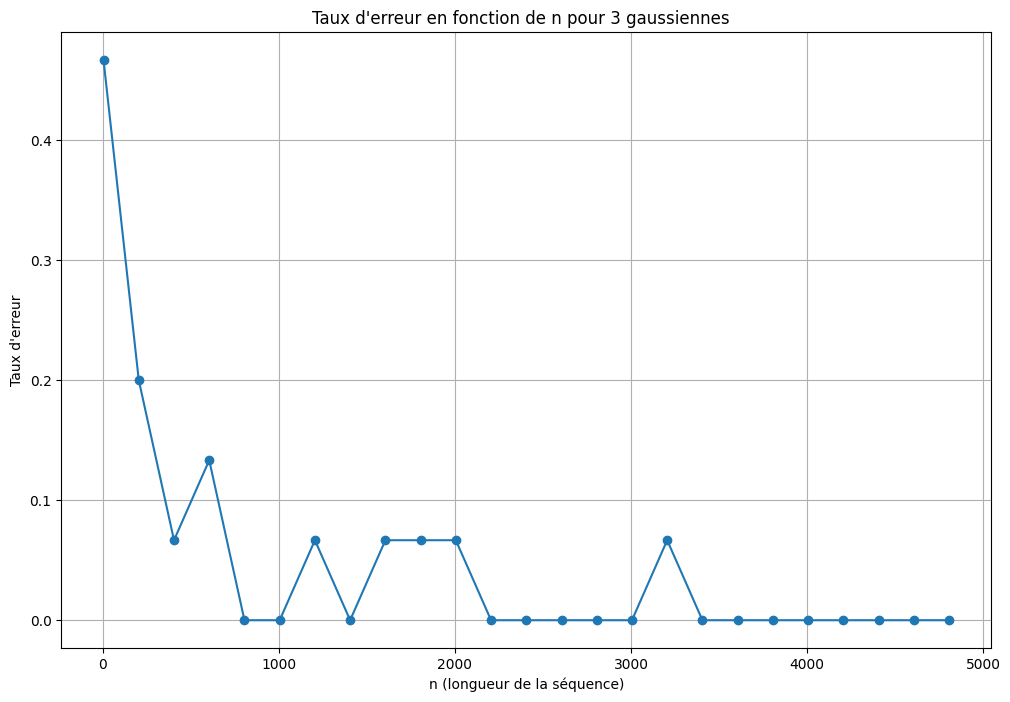

In [4]:
import numpy as np
import itertools
import torch
import matplotlib.pyplot as plt

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)
    data_tensor= data
    #data_tensor = torch.stack(data).to(device)
    #print("data_tensor : ",data_tensor)
    #print( "len(data_tensor) :" , len(data_tensor))
    # Convert data to tensor for MMD function
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            # print( "data_tensor[i:i+1] : ", data_tensor[i:i+1])
            # print( "data_tensor[i:i+1][0] : ", data_tensor[i:i+1][0])
            # print( "centers[0] : ", centers[0])
            # #print("Shape of data_tensor[i:i+1]: ", data_tensor[i:i+1].shape)
            # print("Shape of data_tensor[i:i+1][0]: ", data_tensor[i:i+1][0].shape)
            # print("Shape of centers[0]: ", centers[0].shape)
            # print("centers[0]: ", centers[0])

            
            #print(MMD(data_tensor[i:i+1][0],centers[0],"rbf").item())
            #mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            mmd_dist = max([MMD(data_tensor[i:i+1][0], centers[j], kernel).item() for j in range(len(centers))])
            #print("ok")
            
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    # data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    data_tensor = data

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        #print(centers)
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1][0], center, kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters


def test_offline_clustering(n):
    
    m = 5  # number of similar samples for x and y
    d = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_mean = torch.zeros(d) + 0.1
    y_mean = torch.zeros(d)
    z_mean = torch.zeros(d) + 0.3
    # x_cov = 2 * torch.eye(d)  # Covariance matrix for X
    # y_cov = 4 * torch.eye(d)  # Covariance matrix for Y
    x_cov = torch.eye(d)  # Covariance matrix for X
    y_cov = torch.eye(d)
    z_cov = torch.eye(d)# Covariance matrix for Y
    # Distributions
    px = torch.distributions.MultivariateNormal(x_mean, x_cov)
    qy = torch.distributions.MultivariateNormal(y_mean, y_cov)
    rz = torch.distributions.MultivariateNormal(z_mean, z_cov)
    # Generate n samples for each distribution
    x_samples = [px.sample([n]).to(device) for _ in range(m)]
    y_samples = [qy.sample([n]).to(device) for _ in range(m)]
    z_samples = [rz.sample([n]).to(device) for _ in range(m)]
    # Combine them into a single list
    all_sequences = x_samples + y_samples + z_samples
    num_sequences = len(all_sequences)

    # Définition des clusters corrects
    good_cluster = [
        [i for i in range(len(x_samples))],
        [j for j in range(len(x_samples), len(x_samples) + len(y_samples))],
        [k for k in range(len(x_samples) + len(y_samples), len(all_sequences))]
    ]
    
    permutations_list = list(itertools.permutations(good_cluster))

    mis_classify = [0 for i in range(len(permutations_list))]
    print(mis_classify)
    

    k = 3  # nombre de clusters
    clusters = offline_clustering(all_sequences, k, kernel="rbf", device='cpu')

    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")
        for j in range(len(permutations_list)):
            for i in points:
                if i not in permutations_list[j][cluster_idx]:
                    mis_classify[j] += 1
    
    error_rate = min(mis_classify) / num_sequences
    return error_rate
                

# n=100
# test_offline_clustering(n)


# Boucle pour exécuter test_offline_clustering pour différentes valeurs de n
n_values = range(5, 5000, 200)
error_rates = []

for n in n_values:
    error_rate = test_offline_clustering(n)
    error_rates.append(error_rate)

plt.figure(figsize=(12, 8))
# Tracer le taux d'erreur en fonction de n
plt.plot(n_values, error_rates, marker='o')
plt.xlabel('n (longueur de la séquence)')
plt.ylabel('Taux d\'erreur')
plt.title('Taux d\'erreur en fonction de n pour 3 gaussiennes  ')
plt.grid(True)
plt.show()

# # Exécutez la fonction
# # test_offline_clustering(10)



